In [1]:
import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import umap
import umap.plot

from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from torch.utils.tensorboard import SummaryWriter

In [2]:
file_name = 'D://Xin Zhang/Sensor/conbination/processed_data/All_data_twoinputs.npy'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

debug = True
train_proportion = 0.8
val_prop = 0.3 # Proportion from the train 

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

num_class_level = 1
num_sub_class_level = 0
length_signal = 3000

start_from_checkpoint = False

save_dir = 'Models/Model_v1'

writer1 = SummaryWriter('combination_log')
#writer2 = SummaryWriter('combination_log')

In [3]:
class Classifier(Dataset):
    def __init__(self, file_name):
        
        self.temp_data = np.load( file_name, allow_pickle = True)
                
        self.data_raw = self.temp_data[:,:length_signal]
        self.data_fft = self.temp_data[:,length_signal:-(num_class_level+num_sub_class_level)]
        self.label = self.temp_data[:,-(num_class_level+num_sub_class_level):]

                
    
    def __len__(self):
        
        return len(self.data_raw) 
    
    def __getitem__(self,idx):
        
        
        return self.data_raw[idx,:], self.data_raw[idx,:], self.label[idx]

In [4]:
all_data = Classifier(file_name)

num_samples = len(all_data.data_raw)
print(num_samples)
print(all_data.data_raw.shape)
print(all_data.data_fft.shape)
print(all_data.label.shape)

1094
(1094, 3000)
(1094, 3000)
(1094, 1)


In [5]:
all_data.data_raw = all_data.data_raw.reshape(all_data.data_raw.shape[0], 1, all_data.data_raw.shape[1])
all_data.data_fft = all_data.data_fft.reshape(all_data.data_fft.shape[0], 1, all_data.data_fft.shape[1]) 

# all_data.label = all_data.label.reshape(all_data.label.shape[0], 1, all_data.label.shape[1])
print(all_data.data_raw.shape)
print(all_data.data_fft.shape)
print(all_data.label.shape)

(1094, 1, 3000)
(1094, 1, 3000)
(1094, 1)


In [6]:
batch_size = 10

In [7]:
n_train = round(num_samples * train_proportion)


train_data, test_data = torch.utils.data.random_split(all_data, [n_train, num_samples - n_train])
#train_data, val_data = torch.utils.data.random_split(train_data, [round(n_train * (1-val_prop)), n_train - round(n_train * (1-val_prop))])

#train_loader = dataloader.DataLoader(train_data, shuffle = True, batch_size = batch_size)
#val_loader = dataloader.DataLoader(val_data, shuffle = False, batch_size = batch_size)
test_loader = dataloader.DataLoader(test_data, shuffle = False, batch_size = batch_size)
all_loader = dataloader.DataLoader(all_data, shuffle = False, batch_size = num_samples)

In [8]:
if(debug):
    print('Num samples', num_samples)
    print('Train samples', n_train)
    #print('Valid samples', n_train - round(n_train * (1-val_prop)))
    print('Test samples', num_samples - n_train)
#     print("Num samples", num_samples)
#     print("Train + valid samples", n_train )
#     print("Train samples", round(n_train * (1-val_prop)))
#     print("Test samples", num_samples - n_train )

Num samples 1094
Train samples 875
Test samples 219


### Linear

In [9]:
class LinearModel_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.raw = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(), 
            #nn.Dropout(0.4),
            nn.Linear(1024, 256),
            nn.ReLU())
        
        self.fft = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(), 
            #nn.Dropout(0.4),
            nn.Linear(1024, 256),
            nn.ReLU())
        
        self.visu = nn.Sequential(
            nn.Linear(2*256, 128),
            nn.ReLU(),
            nn.Linear(128, 32))
        
        self.out = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32, num_classes)) 

    def get_weights(self):
        return self.weight
    
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        t_visu = self.visu(t_in)
        out = self.out(t_visu)
        
#         out = self.out(t_in)
        return out
    
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [10]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, hidden6_size, num_classes):
        super().__init__()
        self.raw = nn.Sequential(
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(), 
            #nn.Dropout(0.4),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU())
        
        self.fft = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(1024, hidden3_size),
            nn.ReLU())
        
        self.visu = nn.Sequential(
            nn.Linear(2*hidden3_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size,hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size,hidden4_size))
        
        self.out = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden4_size, num_classes)) 

    def get_weights(self):
        return self.weight
    
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        t_visu = self.visu(t_in)
        out = self.out(t_visu)
        
#         out = self.out(t_in)
        return out
    
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [11]:
def train(model, device, train_loader, optimizer):
    model.train()
    y_true = []
    y_pred = []
    running_loss = 0
    
    for i in train_loader:
        data_raw, data_fft, target = i
        data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
        data_raw = torch.squeeze(data_raw)
        data_fft = torch.squeeze(data_fft)
        
        # Forward
        output = model(data_raw.float(),data_fft.float())
        loss = criterion(output, target.long().squeeze()) 
        running_loss += loss.item()
        
        # Backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Predictions
        pred = np.round(output.cpu().detach())
        target = np.round(target.cpu().detach())             
        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())
    
    y_pred = np.argmax(y_pred, axis=1)
    
    train_loss = running_loss/len(train_loader)
    writer1.add_scalar('train_val_test_loss', train_loss, global_step=epoch)
    train_losses.append(train_loss)
    
    # performance
    train_accuracy = accuracy_score(y_true,y_pred)
    train_acc.append(train_accuracy)
    train_recall = recall_score(y_true,y_pred,average='macro')
    train_precision = precision_score(y_true,y_pred,average='macro')
    train_f1 = f1_score(y_true,y_pred, average='macro')
    
    print("[train metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(train_loss,train_accuracy,train_recall,train_precision,train_f1))

# ==========================================================================================================================================================================
def validation(model, device, validation_loader):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0
    
    with torch.no_grad():
        for i in validation_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist()) 
            y_pred.extend(pred.tolist())
        
    y_pred = np.argmax(y_pred, axis=1)
    val_loss = running_loss/len(validation_loader)
    writer1.add_scalar('train_val_test_loss', val_loss, global_step=epoch)
    eval_losses.append(val_loss)
    
    # performance
    val_accuracy = accuracy_score(y_true,y_pred)
    eval_acc.append(val_accuracy)
    val_recall = recall_score(y_true,y_pred,average='macro')
    val_precision = precision_score(y_true,y_pred,average='macro')
    val_f1 = f1_score(y_true,y_pred, average='macro')
    
    print("[valid  metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(val_loss,val_accuracy,val_recall,val_precision,val_f1))
    
    return val_loss
    
# ==========================================================================================================================================================================
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)

            # the model on the data
            output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            # Predictions
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist()) 
            y_pred.extend(pred.tolist())
            
    y_pred = np.argmax(y_pred, axis=1)
    
    test_loss = running_loss/len(test_loader)
    writer1.add_scalar('train_val_test_loss', test_loss, global_step=epoch)
    test_losses.append(test_loss)
    
    # performance
    test_accuracy = accuracy_score(y_true,y_pred)
    test_acc.append(test_accuracy)
    test_recall = recall_score(y_true,y_pred,average='macro')
    test_precision = precision_score(y_true,y_pred,average='macro')
    test_f1 = f1_score(y_true,y_pred, average='macro')

    print("[test  metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(test_loss,test_accuracy,test_recall,test_precision,test_f1))
    print("*****************************************************************************************")
    
# ==========================================================================================================================================================================    
def test_metrics(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    y_pred_prob = []
    running_loss = 0
    
    softmax = nn.Softmax()
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            # the model on the data
            output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            output = softmax(output)
            
            # Predictions
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist())
            y_pred_prob.extend(output.tolist())
            y_pred.extend(pred.tolist())
     

    y_pred = np.argmax(y_pred, axis=1)

    # confusion matrix
    print(classification_report(y_true, y_pred))
    conf_matrix = get_confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(conf_matrix)
    
    # ROC curve
    y_true_binary = label_binarize(y_true, classes=[i for i in range(11)])
    y_pred_prob = np.array(y_pred_prob)
    get_roc_auc(y_true_binary, y_pred_prob)

# ==========================================================================================================================================================================    
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer,'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()
            
# ==========================================================================================================================================================================    
def visualization(model, device, all_loader):
    model.eval()
    with torch.no_grad():
        for i in all_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            # the model on the data
            output = model(data_raw.float(),data_fft.float())
    return activation['fft']

# ==========================================================================================================================================================================    
def get_confusion_matrix(trues, preds):
    labels = [0,1,2,3,4,5,6,7,8,9,10]
    conf_matrix = confusion_matrix(trues, preds, labels)
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    
    plt.imshow(conf_matrix, cmap=plt.cm.Greens)
    indices = range(conf_matrix.shape[0])
    labels = [0,1,2,3,4,5,6,7,8,9,10]
    plt.xticks(indices, labels)
    plt.yticks(indices, labels)
    plt.colorbar()
    plt.xlabel('y_true')
    plt.ylabel('y_pred')

    for first_index in range(conf_matrix.shape[0]):
        for second_index in range(conf_matrix.shape[1]):
            plt.text(first_index, second_index, conf_matrix[first_index, second_index])
    plt.savefig('heatmap_allclass_confusion_matrix.jpg')
    plt.show()
     
# ==========================================================================================================================================================================        
font = {'size':13, 'weight':'normal', 'color':'black', 'style':'normal'}

def get_roc_auc(trues, preds):
    labels = [0,1,2,3,4,5,6,7,8,9,10]
    nb_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(trues, preds)
    
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
        
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(nb_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            
    # Finally average it and compute AUC
    mean_tpr /= nb_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.xlabel('1 - specificity',fontdict=font,fontweight='bold')
    plt.ylabel('Sensitivity',fontdict=font,fontweight='bold')
#     plt.title('ROC-AUC for all-class',fontdict=font)
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average',color='deeppink', linestyle=':')
    plt.plot(fpr["macro"], tpr["macro"],label='macro-average',color='navy', linestyle=':')
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'gold', 'black', 'pink', 'grey', 'orange'])
    
    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='{0}'.format(i+1))
#         plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='class {0} (AUC={1:0.2f})'.format(i, roc_auc[i]))
#     plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    plt.legend(loc="lower right",fontsize=13,frameon=False,ncol=2)
    plt.savefig("ROC_All-class.png")
    plt.show()
    
# write roc data into csv file ===============================================================================================================
    all_df = pd.DataFrame()
    for i in range(nb_classes):
        fpr_temp_df = pd.DataFrame(fpr[i])
        all_df = pd.concat([all_df,fpr_temp_df],axis=1)
        tpr_temp_df = pd.DataFrame(tpr[i])
        all_df = pd.concat([all_df,tpr_temp_df],axis=1)
    macro_fpr_temp_df = pd.DataFrame(fpr['macro'])
    all_df = pd.concat([all_df,macro_fpr_temp_df],axis=1)
    macro_tpr_temp_df = pd.DataFrame(tpr['macro'])
    all_df = pd.concat([all_df,macro_tpr_temp_df],axis=1)
    micro_fpr_temp_df = pd.DataFrame(fpr['micro'])
    all_df = pd.concat([all_df,micro_fpr_temp_df],axis=1)
    micro_tpr_temp_df = pd.DataFrame(tpr['micro'])
    all_df = pd.concat([all_df,micro_tpr_temp_df],axis=1)
#         print(i,'===============================')
#         print('fpr',fpr[i])
#         print('tpr',tpr[i])
#     print('macro fpr',fpr["macro"])
#     print('macro tpr',tpr["macro"])
#     print('micro fpr',fpr["micro"])
#     print('micro tpr',tpr["micro"])
#     print(type(fpr[0]))
    p_col = ['0 fpr','0 tpr','1 fpr','1 tpr','2 fpr','2 tpr','3 fpr','3 tpr','4 fpr','4 tpr','5 fpr','5 tpr','6 fpr','6 tpr','7 fpr','7 tpr','8 fpr','8 tpr','9 fpr','9 tpr','10 fpr','10 tpr','macro fpr','macro tpr','micro fpr','micro tpr']
    all_df.columns = p_col
    all_df.to_csv('roc_data_all_class.csv')

In [12]:
input_size = 3000
hidden1_size = 1024
hidden2_size = 512
hidden3_size = 128
hidden4_size = 32
hidden5_size = 32
hidden6_size = 16
num_classes = 11
num_epochs = 450
learning_rate = 1e-3

# KFold validation
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=42)

# Creating model and setting loss and optimizer
model = LinearModel_1(input_size,num_classes).to(device)
# model = LinearModel(input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, hidden6_size, num_classes).to(device)
model.visu.register_forward_hook(get_activation('visu'))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
eval_losses = []
test_losses = []
train_acc = []
eval_acc = []
test_acc = []

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(n_train))):
    print('Fold {}'.format(fold+1))
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=train_sampler)
    val_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=val_sampler)
    
    # reset the model
    model.apply(reset_weights)
    min_loss= 100 # ramdom big number
    
    for epoch in range(num_epochs):
    
        print('In epoch {}/{}'.format(epoch+1,num_epochs))
        train(model,device,train_loader,optimizer)
        val_loss = validation(model,device,val_loader)
        # test(model,device,test_loader)
        
        if(val_loss<min_loss):
            min_loss = val_loss
            print(f'================================save model_{fold+1}================================')
            torch.save(model.state_dict(), f'Model1_Fold_{fold+1}_allclass_twoinputs_net_parameter.pth')

Fold 1
Reset trainable parameters of layer = Linear(in_features=3000, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=3000, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/450


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[train metrics] loss:2.3473 accuracy:0.0886 recall:0.0933 precision:0.0162 f1:0.0267
[valid  metrics] loss:2.2899 accuracy:0.1600 recall:0.1107 precision:0.0390 f1:0.0474
================================save model_1================================
In epoch 2/450
[train metrics] loss:2.2922 accuracy:0.1386 recall:0.1172 precision:0.0321 f1:0.0470
[valid  metrics] loss:2.2924 accuracy:0.1429 recall:0.1136 precision:0.0280 f1:0.0407
In epoch 3/450
[train metrics] loss:2.2635 accuracy:0.1314 recall:0.1195 precision:0.0238 f1:0.0394
[valid  metrics] loss:2.2005 accuracy:0.1657 recall:0.1739 precision:0.0322 f1:0.0519
================================save model_1================================
In epoch 4/450
[train metrics] loss:2.0341 accuracy:0.2000 recall:0.1757 precision:0.0746 f1:0.0826
[valid  metrics] loss:1.7267 accuracy:0.2229 recall:0.1542 precision:0.0510 f1:0.0723
================================save model_1================================
In epoch 5/450
[train metrics] loss:1.66

[train metrics] loss:0.6700 accuracy:0.7186 recall:0.6658 precision:0.6556 f1:0.6472
[valid  metrics] loss:0.7243 accuracy:0.7029 recall:0.6369 precision:0.6320 f1:0.6140
In epoch 39/450
[train metrics] loss:0.7350 accuracy:0.6886 recall:0.6486 precision:0.6453 f1:0.6303
[valid  metrics] loss:0.6047 accuracy:0.7943 recall:0.7418 precision:0.7744 f1:0.7153
In epoch 40/450
[train metrics] loss:0.6281 accuracy:0.7429 recall:0.7030 precision:0.7066 f1:0.6848
[valid  metrics] loss:0.6060 accuracy:0.7543 recall:0.6818 precision:0.7115 f1:0.6728
In epoch 41/450
[train metrics] loss:0.6358 accuracy:0.7329 recall:0.6990 precision:0.6986 f1:0.6794
[valid  metrics] loss:0.5583 accuracy:0.7829 recall:0.7411 precision:0.7502 f1:0.7285
================================save model_1================================
In epoch 42/450
[train metrics] loss:0.6208 accuracy:0.7357 recall:0.6900 precision:0.6890 f1:0.6726
[valid  metrics] loss:0.6625 accuracy:0.6686 recall:0.6496 precision:0.6353 f1:0.5827
In e

[train metrics] loss:0.5384 accuracy:0.7657 recall:0.7158 precision:0.7097 f1:0.7028
[valid  metrics] loss:0.4752 accuracy:0.7771 recall:0.7064 precision:0.7463 f1:0.6888
In epoch 80/450
[train metrics] loss:0.5834 accuracy:0.7486 recall:0.7076 precision:0.7067 f1:0.6991
[valid  metrics] loss:0.5386 accuracy:0.7600 recall:0.7414 precision:0.8030 f1:0.7233
In epoch 81/450
[train metrics] loss:0.5336 accuracy:0.7557 recall:0.6924 precision:0.6912 f1:0.6847
[valid  metrics] loss:0.4458 accuracy:0.8171 recall:0.7498 precision:0.7629 f1:0.7405
In epoch 82/450
[train metrics] loss:0.5768 accuracy:0.7571 recall:0.7090 precision:0.7063 f1:0.6991
[valid  metrics] loss:0.4272 accuracy:0.8171 recall:0.7463 precision:0.7587 f1:0.7448
================================save model_1================================
In epoch 83/450
[train metrics] loss:0.5389 accuracy:0.7729 recall:0.7320 precision:0.7347 f1:0.7222
[valid  metrics] loss:0.5941 accuracy:0.7943 recall:0.7445 precision:0.7646 f1:0.7390
In e

[train metrics] loss:0.5370 accuracy:0.7843 recall:0.7430 precision:0.7474 f1:0.7337
[valid  metrics] loss:0.4487 accuracy:0.8400 recall:0.7936 precision:0.7950 f1:0.7724
In epoch 123/450
[train metrics] loss:0.4657 accuracy:0.8014 recall:0.7404 precision:0.7381 f1:0.7359
[valid  metrics] loss:0.4079 accuracy:0.8171 recall:0.7664 precision:0.7704 f1:0.7569
In epoch 124/450
[train metrics] loss:0.4953 accuracy:0.7743 recall:0.7079 precision:0.7007 f1:0.6963
[valid  metrics] loss:0.4745 accuracy:0.7886 recall:0.7342 precision:0.7594 f1:0.7254
In epoch 125/450
[train metrics] loss:0.4975 accuracy:0.7971 recall:0.7470 precision:0.7452 f1:0.7341
[valid  metrics] loss:0.4506 accuracy:0.8457 recall:0.7890 precision:0.8508 f1:0.7948
In epoch 126/450
[train metrics] loss:0.4750 accuracy:0.8029 recall:0.7463 precision:0.7403 f1:0.7372
[valid  metrics] loss:0.4294 accuracy:0.8114 recall:0.7555 precision:0.7955 f1:0.7266
In epoch 127/450
[train metrics] loss:0.5553 accuracy:0.7657 recall:0.7180 pr

[train metrics] loss:0.4784 accuracy:0.7971 recall:0.7524 precision:0.7497 f1:0.7431
[valid  metrics] loss:0.3587 accuracy:0.8514 recall:0.8112 precision:0.8154 f1:0.7918
In epoch 166/450
[train metrics] loss:0.4174 accuracy:0.8200 recall:0.7678 precision:0.7717 f1:0.7641
[valid  metrics] loss:0.3679 accuracy:0.8571 recall:0.8268 precision:0.8137 f1:0.8036
In epoch 167/450
[train metrics] loss:0.4572 accuracy:0.8086 recall:0.7585 precision:0.7620 f1:0.7532
[valid  metrics] loss:0.4344 accuracy:0.8286 recall:0.7770 precision:0.7838 f1:0.7696
In epoch 168/450
[train metrics] loss:0.4626 accuracy:0.8043 recall:0.7575 precision:0.7680 f1:0.7488
[valid  metrics] loss:0.7105 accuracy:0.6971 recall:0.6635 precision:0.6136 f1:0.6175
In epoch 169/450
[train metrics] loss:0.4819 accuracy:0.7886 recall:0.7349 precision:0.7315 f1:0.7257
[valid  metrics] loss:0.3323 accuracy:0.8743 recall:0.8311 precision:0.8236 f1:0.8156
================================save model_1================================


[train metrics] loss:0.4274 accuracy:0.8229 recall:0.7820 precision:0.7876 f1:0.7810
[valid  metrics] loss:0.4672 accuracy:0.7943 recall:0.7131 precision:0.7310 f1:0.7147
In epoch 209/450
[train metrics] loss:0.4063 accuracy:0.8243 recall:0.7653 precision:0.7595 f1:0.7563
[valid  metrics] loss:0.3833 accuracy:0.8343 recall:0.7800 precision:0.7774 f1:0.7691
In epoch 210/450
[train metrics] loss:0.4616 accuracy:0.8000 recall:0.7480 precision:0.7419 f1:0.7420
[valid  metrics] loss:0.3445 accuracy:0.8629 recall:0.8307 precision:0.8304 f1:0.8150
In epoch 211/450
[train metrics] loss:0.3897 accuracy:0.8143 recall:0.7526 precision:0.7609 f1:0.7482
[valid  metrics] loss:0.3648 accuracy:0.8286 recall:0.7558 precision:0.7652 f1:0.7579
In epoch 212/450
[train metrics] loss:0.3706 accuracy:0.8329 recall:0.7850 precision:0.7819 f1:0.7763
[valid  metrics] loss:0.3447 accuracy:0.8571 recall:0.8293 precision:0.8289 f1:0.8135
In epoch 213/450
[train metrics] loss:0.4559 accuracy:0.7914 recall:0.7364 pr

[train metrics] loss:0.4121 accuracy:0.8200 recall:0.7652 precision:0.7678 f1:0.7609
[valid  metrics] loss:0.3139 accuracy:0.8743 recall:0.8040 precision:0.8124 f1:0.8044
================================save model_1================================
In epoch 252/450
[train metrics] loss:0.4101 accuracy:0.8129 recall:0.7592 precision:0.7734 f1:0.7506
[valid  metrics] loss:0.4016 accuracy:0.8114 recall:0.7460 precision:0.7001 f1:0.7116
In epoch 253/450
[train metrics] loss:0.3855 accuracy:0.8386 recall:0.7896 precision:0.7894 f1:0.7834
[valid  metrics] loss:0.3587 accuracy:0.8229 recall:0.7766 precision:0.7894 f1:0.7738
In epoch 254/450
[train metrics] loss:0.4091 accuracy:0.8271 recall:0.7881 precision:0.7790 f1:0.7806
[valid  metrics] loss:0.3773 accuracy:0.8514 recall:0.8219 precision:0.8273 f1:0.8080
In epoch 255/450
[train metrics] loss:0.3813 accuracy:0.8200 recall:0.7519 precision:0.7490 f1:0.7444
[valid  metrics] loss:0.3394 accuracy:0.8629 recall:0.8114 precision:0.8125 f1:0.8037


[train metrics] loss:0.4020 accuracy:0.8329 recall:0.7810 precision:0.7816 f1:0.7750
[valid  metrics] loss:0.4859 accuracy:0.8457 recall:0.8123 precision:0.8147 f1:0.7993
In epoch 295/450
[train metrics] loss:0.3799 accuracy:0.8286 recall:0.7693 precision:0.7770 f1:0.7658
[valid  metrics] loss:0.3051 accuracy:0.8800 recall:0.8235 precision:0.8267 f1:0.8195
In epoch 296/450
[train metrics] loss:0.3780 accuracy:0.8286 recall:0.7798 precision:0.7873 f1:0.7712
[valid  metrics] loss:0.3436 accuracy:0.8629 recall:0.8093 precision:0.8105 f1:0.7994
In epoch 297/450
[train metrics] loss:0.3529 accuracy:0.8386 recall:0.7883 precision:0.7873 f1:0.7823
[valid  metrics] loss:0.3488 accuracy:0.8686 recall:0.8281 precision:0.8222 f1:0.8147
In epoch 298/450
[train metrics] loss:0.3798 accuracy:0.8329 recall:0.7767 precision:0.7741 f1:0.7710
[valid  metrics] loss:0.5135 accuracy:0.7657 recall:0.7026 precision:0.7366 f1:0.6835
In epoch 299/450
[train metrics] loss:0.3704 accuracy:0.8371 recall:0.7838 pr

[train metrics] loss:0.3775 accuracy:0.8314 recall:0.7678 precision:0.7747 f1:0.7685
[valid  metrics] loss:0.3445 accuracy:0.8514 recall:0.8066 precision:0.8184 f1:0.7986
In epoch 339/450
[train metrics] loss:0.4732 accuracy:0.8114 recall:0.7601 precision:0.7633 f1:0.7591
[valid  metrics] loss:0.4009 accuracy:0.8514 recall:0.7853 precision:0.8007 f1:0.7834
In epoch 340/450
[train metrics] loss:0.3693 accuracy:0.8314 recall:0.7637 precision:0.7678 f1:0.7597
[valid  metrics] loss:0.3731 accuracy:0.8514 recall:0.7936 precision:0.8046 f1:0.7901
In epoch 341/450
[train metrics] loss:0.3735 accuracy:0.8371 recall:0.7888 precision:0.8019 f1:0.7856
[valid  metrics] loss:0.4309 accuracy:0.8000 recall:0.7670 precision:0.7818 f1:0.7392
In epoch 342/450
[train metrics] loss:0.3423 accuracy:0.8443 recall:0.7996 precision:0.8064 f1:0.7965
[valid  metrics] loss:0.3121 accuracy:0.8743 recall:0.8260 precision:0.8356 f1:0.8126
In epoch 343/450
[train metrics] loss:0.3589 accuracy:0.8429 recall:0.7865 pr

[train metrics] loss:0.3240 accuracy:0.8529 recall:0.8000 precision:0.8094 f1:0.7974
[valid  metrics] loss:0.4418 accuracy:0.7714 recall:0.7314 precision:0.6750 f1:0.6754
In epoch 383/450
[train metrics] loss:0.4229 accuracy:0.8243 recall:0.7728 precision:0.7797 f1:0.7715
[valid  metrics] loss:0.2962 accuracy:0.8914 recall:0.8504 precision:0.8450 f1:0.8400
In epoch 384/450
[train metrics] loss:0.3163 accuracy:0.8586 recall:0.8073 precision:0.8079 f1:0.8029
[valid  metrics] loss:0.3311 accuracy:0.8571 recall:0.8115 precision:0.8070 f1:0.8039
In epoch 385/450
[train metrics] loss:0.3094 accuracy:0.8600 recall:0.8078 precision:0.8097 f1:0.8039
[valid  metrics] loss:0.4512 accuracy:0.7829 recall:0.7258 precision:0.6934 f1:0.6914
In epoch 386/450
[train metrics] loss:0.3567 accuracy:0.8529 recall:0.7923 precision:0.7995 f1:0.7907
[valid  metrics] loss:0.3659 accuracy:0.8571 recall:0.7937 precision:0.7877 f1:0.7826
In epoch 387/450
[train metrics] loss:0.4552 accuracy:0.8086 recall:0.7476 pr

[train metrics] loss:0.2983 accuracy:0.8771 recall:0.8303 precision:0.8454 f1:0.8312
[valid  metrics] loss:0.3255 accuracy:0.8800 recall:0.8341 precision:0.8279 f1:0.8241
In epoch 427/450
[train metrics] loss:0.3102 accuracy:0.8629 recall:0.8176 precision:0.8277 f1:0.8170
[valid  metrics] loss:0.3278 accuracy:0.8800 recall:0.8057 precision:0.7987 f1:0.7974
In epoch 428/450
[train metrics] loss:0.3219 accuracy:0.8471 recall:0.7874 precision:0.7881 f1:0.7841
[valid  metrics] loss:0.2840 accuracy:0.8800 recall:0.8230 precision:0.8741 f1:0.8259
================================save model_1================================
In epoch 429/450
[train metrics] loss:0.3148 accuracy:0.8500 recall:0.7942 precision:0.8070 f1:0.7890
[valid  metrics] loss:0.3114 accuracy:0.8629 recall:0.8026 precision:0.8009 f1:0.7997
In epoch 430/450
[train metrics] loss:0.3509 accuracy:0.8386 recall:0.7923 precision:0.8002 f1:0.7913
[valid  metrics] loss:0.5268 accuracy:0.8057 recall:0.7546 precision:0.7896 f1:0.7189


[train metrics] loss:1.0901 accuracy:0.5300 recall:0.5017 precision:0.4837 f1:0.4566
[valid  metrics] loss:1.0466 accuracy:0.5943 recall:0.5323 precision:0.5661 f1:0.4552
In epoch 14/450
[train metrics] loss:0.9325 accuracy:0.6057 recall:0.5940 precision:0.6198 f1:0.5567
[valid  metrics] loss:0.8891 accuracy:0.6343 recall:0.6066 precision:0.6482 f1:0.5816
================================save model_2================================
In epoch 15/450
[train metrics] loss:0.8906 accuracy:0.6429 recall:0.6040 precision:0.6165 f1:0.5875
[valid  metrics] loss:1.0309 accuracy:0.6629 recall:0.5741 precision:0.5722 f1:0.5427
In epoch 16/450
[train metrics] loss:0.9555 accuracy:0.5614 recall:0.5227 precision:0.5018 f1:0.4874
[valid  metrics] loss:0.9301 accuracy:0.6514 recall:0.5632 precision:0.5310 f1:0.5081
In epoch 17/450
[train metrics] loss:0.8808 accuracy:0.5757 recall:0.5260 precision:0.4915 f1:0.4840
[valid  metrics] loss:0.8604 accuracy:0.7143 recall:0.6442 precision:0.6597 f1:0.5957
====

[train metrics] loss:0.6710 accuracy:0.7071 recall:0.6661 precision:0.6671 f1:0.6416
[valid  metrics] loss:0.6532 accuracy:0.7714 recall:0.6777 precision:0.7176 f1:0.6374
================================save model_2================================
In epoch 55/450
[train metrics] loss:0.6505 accuracy:0.7214 recall:0.6906 precision:0.7191 f1:0.6631
[valid  metrics] loss:0.6637 accuracy:0.7714 recall:0.6877 precision:0.6736 f1:0.6547
In epoch 56/450
[train metrics] loss:0.6502 accuracy:0.7229 recall:0.6857 precision:0.6461 f1:0.6490
[valid  metrics] loss:0.6632 accuracy:0.7714 recall:0.6875 precision:0.7274 f1:0.6549
In epoch 57/450
[train metrics] loss:0.6566 accuracy:0.6957 recall:0.6506 precision:0.6409 f1:0.6242
[valid  metrics] loss:0.6785 accuracy:0.7886 recall:0.7091 precision:0.7144 f1:0.6766
In epoch 58/450
[train metrics] loss:0.6426 accuracy:0.7129 recall:0.6808 precision:0.6385 f1:0.6412
[valid  metrics] loss:0.6730 accuracy:0.7657 recall:0.6809 precision:0.7081 f1:0.6480
In e

[train metrics] loss:0.5516 accuracy:0.7714 recall:0.7281 precision:0.7298 f1:0.7148
[valid  metrics] loss:0.6248 accuracy:0.8000 recall:0.6736 precision:0.7450 f1:0.6817
In epoch 97/450
[train metrics] loss:0.6288 accuracy:0.7257 recall:0.6823 precision:0.6774 f1:0.6616
[valid  metrics] loss:0.7266 accuracy:0.7943 recall:0.7094 precision:0.6888 f1:0.6877
In epoch 98/450
[train metrics] loss:0.5981 accuracy:0.7471 recall:0.7139 precision:0.7201 f1:0.6996
[valid  metrics] loss:0.5829 accuracy:0.8000 recall:0.7119 precision:0.7371 f1:0.6955
================================save model_2================================
In epoch 99/450
[train metrics] loss:0.5602 accuracy:0.7614 recall:0.7195 precision:0.7362 f1:0.7038
[valid  metrics] loss:0.6057 accuracy:0.8114 recall:0.7145 precision:0.7394 f1:0.6837
In epoch 100/450
[train metrics] loss:0.6032 accuracy:0.7386 recall:0.7041 precision:0.6949 f1:0.6906
[valid  metrics] loss:0.6984 accuracy:0.7543 recall:0.6745 precision:0.7035 f1:0.6427
In 

[train metrics] loss:0.5582 accuracy:0.7700 recall:0.7270 precision:0.7265 f1:0.7145
[valid  metrics] loss:0.7016 accuracy:0.7543 recall:0.6874 precision:0.6714 f1:0.6475
In epoch 139/450
[train metrics] loss:0.4693 accuracy:0.7957 recall:0.7494 precision:0.7508 f1:0.7375
[valid  metrics] loss:0.7463 accuracy:0.7429 recall:0.6791 precision:0.6938 f1:0.6412
In epoch 140/450
[train metrics] loss:0.4985 accuracy:0.7829 recall:0.7296 precision:0.7240 f1:0.7167
[valid  metrics] loss:0.6243 accuracy:0.7943 recall:0.7194 precision:0.7806 f1:0.7187
In epoch 141/450
[train metrics] loss:0.5089 accuracy:0.7914 recall:0.7532 precision:0.7599 f1:0.7461
[valid  metrics] loss:0.6479 accuracy:0.8057 recall:0.7182 precision:0.7031 f1:0.6875
In epoch 142/450
[train metrics] loss:0.4795 accuracy:0.7957 recall:0.7557 precision:0.7581 f1:0.7415
[valid  metrics] loss:0.6267 accuracy:0.8000 recall:0.6994 precision:0.7337 f1:0.6894
In epoch 143/450
[train metrics] loss:0.4602 accuracy:0.7971 recall:0.7515 pr

[train metrics] loss:0.4518 accuracy:0.8086 recall:0.7646 precision:0.7651 f1:0.7605
[valid  metrics] loss:0.5775 accuracy:0.8400 recall:0.7129 precision:0.6711 f1:0.6853
In epoch 182/450
[train metrics] loss:0.5273 accuracy:0.7714 recall:0.7330 precision:0.7266 f1:0.7243
[valid  metrics] loss:0.5598 accuracy:0.8114 recall:0.7004 precision:0.6929 f1:0.6773
In epoch 183/450
[train metrics] loss:0.5116 accuracy:0.7814 recall:0.7323 precision:0.7327 f1:0.7253
[valid  metrics] loss:0.5376 accuracy:0.8286 recall:0.7261 precision:0.7749 f1:0.7255
In epoch 184/450
[train metrics] loss:0.4351 accuracy:0.8186 recall:0.7713 precision:0.7641 f1:0.7619
[valid  metrics] loss:0.6056 accuracy:0.8114 recall:0.7153 precision:0.7164 f1:0.7110
In epoch 185/450
[train metrics] loss:0.4359 accuracy:0.8043 recall:0.7682 precision:0.7721 f1:0.7625
[valid  metrics] loss:0.5679 accuracy:0.8286 recall:0.7284 precision:0.7571 f1:0.6993
In epoch 186/450
[train metrics] loss:0.4972 accuracy:0.7971 recall:0.7523 pr

[train metrics] loss:0.3995 accuracy:0.8329 recall:0.7863 precision:0.7881 f1:0.7808
[valid  metrics] loss:0.6137 accuracy:0.8114 recall:0.7027 precision:0.6966 f1:0.6880
In epoch 225/450
[train metrics] loss:0.4179 accuracy:0.8129 recall:0.7589 precision:0.7546 f1:0.7542
[valid  metrics] loss:0.7618 accuracy:0.7543 recall:0.6707 precision:0.6722 f1:0.6499
In epoch 226/450
[train metrics] loss:0.4095 accuracy:0.8214 recall:0.7700 precision:0.7711 f1:0.7673
[valid  metrics] loss:0.5874 accuracy:0.8114 recall:0.6621 precision:0.6546 f1:0.6481
In epoch 227/450
[train metrics] loss:0.4017 accuracy:0.8243 recall:0.7696 precision:0.7664 f1:0.7641
[valid  metrics] loss:0.6123 accuracy:0.8457 recall:0.7535 precision:0.7797 f1:0.7446
In epoch 228/450
[train metrics] loss:0.4224 accuracy:0.8229 recall:0.7890 precision:0.7946 f1:0.7798
[valid  metrics] loss:0.6309 accuracy:0.8057 recall:0.6865 precision:0.6930 f1:0.6797
In epoch 229/450
[train metrics] loss:0.4492 accuracy:0.8271 recall:0.7949 pr

[train metrics] loss:0.4125 accuracy:0.8200 recall:0.7721 precision:0.7765 f1:0.7710
[valid  metrics] loss:0.6079 accuracy:0.7829 recall:0.6113 precision:0.5942 f1:0.5995
In epoch 269/450
[train metrics] loss:0.3933 accuracy:0.8243 recall:0.7745 precision:0.7704 f1:0.7702
[valid  metrics] loss:0.5573 accuracy:0.8286 recall:0.7375 precision:0.7559 f1:0.7164
In epoch 270/450
[train metrics] loss:0.3870 accuracy:0.8400 recall:0.8028 precision:0.8032 f1:0.7976
[valid  metrics] loss:0.6578 accuracy:0.8171 recall:0.6818 precision:0.7317 f1:0.6719
In epoch 271/450
[train metrics] loss:0.3645 accuracy:0.8429 recall:0.7992 precision:0.8037 f1:0.7980
[valid  metrics] loss:0.5578 accuracy:0.7886 recall:0.6786 precision:0.6696 f1:0.6653
In epoch 272/450
[train metrics] loss:0.3666 accuracy:0.8529 recall:0.8097 precision:0.8093 f1:0.8071
[valid  metrics] loss:0.5668 accuracy:0.8343 recall:0.7481 precision:0.7719 f1:0.7156
In epoch 273/450
[train metrics] loss:0.3677 accuracy:0.8371 recall:0.7938 pr

[train metrics] loss:0.3899 accuracy:0.8314 recall:0.7856 precision:0.7817 f1:0.7784
[valid  metrics] loss:0.7111 accuracy:0.8114 recall:0.7462 precision:0.7256 f1:0.7256
In epoch 313/450
[train metrics] loss:0.3583 accuracy:0.8429 recall:0.7941 precision:0.7928 f1:0.7898
[valid  metrics] loss:0.6583 accuracy:0.7829 recall:0.7098 precision:0.6965 f1:0.6862
In epoch 314/450
[train metrics] loss:0.3365 accuracy:0.8671 recall:0.8412 precision:0.8350 f1:0.8326
[valid  metrics] loss:0.5949 accuracy:0.8514 recall:0.7863 precision:0.8360 f1:0.7714
In epoch 315/450
[train metrics] loss:0.3580 accuracy:0.8314 recall:0.7757 precision:0.7791 f1:0.7715
[valid  metrics] loss:0.5683 accuracy:0.8343 recall:0.6995 precision:0.7380 f1:0.6874
In epoch 316/450
[train metrics] loss:0.3575 accuracy:0.8429 recall:0.7956 precision:0.7925 f1:0.7898
[valid  metrics] loss:0.5581 accuracy:0.8343 recall:0.7480 precision:0.7618 f1:0.7459
In epoch 317/450
[train metrics] loss:0.4069 accuracy:0.8243 recall:0.7717 pr

[train metrics] loss:0.3421 accuracy:0.8429 recall:0.7961 precision:0.7981 f1:0.7861
[valid  metrics] loss:0.5369 accuracy:0.8171 recall:0.6651 precision:0.7369 f1:0.6693
In epoch 357/450
[train metrics] loss:0.4428 accuracy:0.8114 recall:0.7617 precision:0.7666 f1:0.7600
[valid  metrics] loss:0.6318 accuracy:0.7943 recall:0.6888 precision:0.7345 f1:0.6705
In epoch 358/450
[train metrics] loss:0.4587 accuracy:0.8200 recall:0.7756 precision:0.7777 f1:0.7711
[valid  metrics] loss:0.5526 accuracy:0.8286 recall:0.6970 precision:0.7511 f1:0.6893
In epoch 359/450
[train metrics] loss:0.3476 accuracy:0.8414 recall:0.8045 precision:0.8065 f1:0.8000
[valid  metrics] loss:0.5852 accuracy:0.8171 recall:0.7068 precision:0.7356 f1:0.6982
In epoch 360/450
[train metrics] loss:0.3523 accuracy:0.8457 recall:0.8063 precision:0.8064 f1:0.7984
[valid  metrics] loss:0.5896 accuracy:0.8229 recall:0.7223 precision:0.7619 f1:0.7022
In epoch 361/450
[train metrics] loss:0.3549 accuracy:0.8486 recall:0.7982 pr

[train metrics] loss:0.3333 accuracy:0.8529 recall:0.7991 precision:0.8008 f1:0.7975
[valid  metrics] loss:0.5205 accuracy:0.8400 recall:0.7455 precision:0.7683 f1:0.7265
In epoch 401/450
[train metrics] loss:0.3330 accuracy:0.8643 recall:0.8283 precision:0.8342 f1:0.8242
[valid  metrics] loss:0.6043 accuracy:0.8571 recall:0.7327 precision:0.7701 f1:0.7169
In epoch 402/450
[train metrics] loss:0.3408 accuracy:0.8429 recall:0.7929 precision:0.7878 f1:0.7893
[valid  metrics] loss:0.5241 accuracy:0.8171 recall:0.6745 precision:0.7474 f1:0.6723
In epoch 403/450
[train metrics] loss:0.4194 accuracy:0.8243 recall:0.7670 precision:0.7703 f1:0.7613
[valid  metrics] loss:0.5521 accuracy:0.8286 recall:0.7215 precision:0.7228 f1:0.6990
In epoch 404/450
[train metrics] loss:0.3553 accuracy:0.8343 recall:0.7863 precision:0.7836 f1:0.7829
[valid  metrics] loss:0.5936 accuracy:0.8229 recall:0.7372 precision:0.7820 f1:0.7348
In epoch 405/450
[train metrics] loss:0.3472 accuracy:0.8457 recall:0.7968 pr

[train metrics] loss:0.3649 accuracy:0.8486 recall:0.8010 precision:0.8030 f1:0.7984
[valid  metrics] loss:0.6272 accuracy:0.8457 recall:0.7794 precision:0.7560 f1:0.7533
In epoch 445/450
[train metrics] loss:0.3233 accuracy:0.8729 recall:0.8279 precision:0.8236 f1:0.8242
[valid  metrics] loss:0.6582 accuracy:0.8171 recall:0.7229 precision:0.7497 f1:0.6908
In epoch 446/450
[train metrics] loss:0.3216 accuracy:0.8571 recall:0.8089 precision:0.8107 f1:0.8060
[valid  metrics] loss:0.5429 accuracy:0.8400 recall:0.7523 precision:0.7424 f1:0.7277
In epoch 447/450
[train metrics] loss:0.3306 accuracy:0.8671 recall:0.8213 precision:0.8190 f1:0.8171
[valid  metrics] loss:0.5709 accuracy:0.8286 recall:0.7148 precision:0.7483 f1:0.7042
In epoch 448/450
[train metrics] loss:0.3213 accuracy:0.8571 recall:0.8153 precision:0.8230 f1:0.8103
[valid  metrics] loss:0.5755 accuracy:0.8400 recall:0.7094 precision:0.7588 f1:0.6981
In epoch 449/450
[train metrics] loss:0.3928 accuracy:0.8457 recall:0.8037 pr

[train metrics] loss:0.7042 accuracy:0.7100 recall:0.6608 precision:0.6294 f1:0.6265
[valid  metrics] loss:0.7376 accuracy:0.7086 recall:0.6809 precision:0.6869 f1:0.6664
================================save model_3================================
In epoch 30/450
[train metrics] loss:0.7048 accuracy:0.7057 recall:0.6540 precision:0.6516 f1:0.6277
[valid  metrics] loss:0.7467 accuracy:0.7029 recall:0.6769 precision:0.6647 f1:0.6163
In epoch 31/450
[train metrics] loss:0.6792 accuracy:0.7043 recall:0.6494 precision:0.6128 f1:0.6168
[valid  metrics] loss:0.9403 accuracy:0.5771 recall:0.5588 precision:0.5249 f1:0.5043
In epoch 32/450
[train metrics] loss:0.7172 accuracy:0.7043 recall:0.6498 precision:0.6179 f1:0.6120
[valid  metrics] loss:0.7785 accuracy:0.6971 recall:0.6849 precision:0.6513 f1:0.6270
In epoch 33/450
[train metrics] loss:0.6949 accuracy:0.7071 recall:0.6485 precision:0.6167 f1:0.6179
[valid  metrics] loss:0.8027 accuracy:0.6514 recall:0.6262 precision:0.5497 f1:0.5599
In e

[train metrics] loss:0.6316 accuracy:0.7414 recall:0.6815 precision:0.7110 f1:0.6603
[valid  metrics] loss:0.6796 accuracy:0.7371 recall:0.6908 precision:0.6658 f1:0.6636
In epoch 71/450
[train metrics] loss:0.5675 accuracy:0.7771 recall:0.7145 precision:0.7199 f1:0.6899
[valid  metrics] loss:0.7095 accuracy:0.6629 recall:0.6285 precision:0.6113 f1:0.5706
In epoch 72/450
[train metrics] loss:0.5844 accuracy:0.7586 recall:0.6967 precision:0.6745 f1:0.6692
[valid  metrics] loss:0.6896 accuracy:0.7429 recall:0.7270 precision:0.6727 f1:0.6764
In epoch 73/450
[train metrics] loss:0.5607 accuracy:0.7714 recall:0.7082 precision:0.6768 f1:0.6799
[valid  metrics] loss:0.6188 accuracy:0.7029 recall:0.6681 precision:0.6374 f1:0.6321
================================save model_3================================
In epoch 74/450
[train metrics] loss:0.5361 accuracy:0.7600 recall:0.6944 precision:0.6862 f1:0.6744
[valid  metrics] loss:0.8484 accuracy:0.7143 recall:0.6918 precision:0.6351 f1:0.6395
In e

[train metrics] loss:0.5225 accuracy:0.7800 recall:0.7228 precision:0.7172 f1:0.7089
[valid  metrics] loss:0.7456 accuracy:0.7829 recall:0.7689 precision:0.8133 f1:0.7439
In epoch 114/450
[train metrics] loss:0.4661 accuracy:0.7957 recall:0.7348 precision:0.7388 f1:0.7313
[valid  metrics] loss:0.8397 accuracy:0.7086 recall:0.7060 precision:0.6413 f1:0.6518
In epoch 115/450
[train metrics] loss:0.5545 accuracy:0.7743 recall:0.7100 precision:0.7110 f1:0.6970
[valid  metrics] loss:0.7312 accuracy:0.7486 recall:0.7366 precision:0.7236 f1:0.6987
In epoch 116/450
[train metrics] loss:0.4829 accuracy:0.7900 recall:0.7244 precision:0.7154 f1:0.7137
[valid  metrics] loss:0.7662 accuracy:0.7543 recall:0.7469 precision:0.7415 f1:0.7211
In epoch 117/450
[train metrics] loss:0.4806 accuracy:0.7986 recall:0.7289 precision:0.7301 f1:0.7166
[valid  metrics] loss:0.6248 accuracy:0.7429 recall:0.6902 precision:0.6893 f1:0.6753
In epoch 118/450
[train metrics] loss:0.5395 accuracy:0.7714 recall:0.7100 pr

[train metrics] loss:0.4573 accuracy:0.8114 recall:0.7364 precision:0.7165 f1:0.7225
[valid  metrics] loss:0.7349 accuracy:0.7771 recall:0.7614 precision:0.7518 f1:0.7450
In epoch 158/450
[train metrics] loss:0.4641 accuracy:0.7943 recall:0.7213 precision:0.7156 f1:0.7088
[valid  metrics] loss:0.7755 accuracy:0.7600 recall:0.7200 precision:0.7697 f1:0.7141
In epoch 159/450
[train metrics] loss:0.4735 accuracy:0.8071 recall:0.7428 precision:0.7481 f1:0.7376
[valid  metrics] loss:0.6525 accuracy:0.7429 recall:0.7147 precision:0.6821 f1:0.6763
In epoch 160/450
[train metrics] loss:0.4848 accuracy:0.8086 recall:0.7327 precision:0.7318 f1:0.7258
[valid  metrics] loss:0.9005 accuracy:0.7371 recall:0.7222 precision:0.7682 f1:0.7091
In epoch 161/450
[train metrics] loss:0.4671 accuracy:0.8100 recall:0.7408 precision:0.7468 f1:0.7368
[valid  metrics] loss:0.6841 accuracy:0.7371 recall:0.6987 precision:0.6848 f1:0.6861
In epoch 162/450
[train metrics] loss:0.4413 accuracy:0.8086 recall:0.7442 pr

[train metrics] loss:0.4041 accuracy:0.8229 recall:0.7616 precision:0.7563 f1:0.7550
[valid  metrics] loss:0.7027 accuracy:0.7886 recall:0.7510 precision:0.7722 f1:0.7487
In epoch 202/450
[train metrics] loss:0.4351 accuracy:0.8157 recall:0.7475 precision:0.7378 f1:0.7321
[valid  metrics] loss:0.6382 accuracy:0.7886 recall:0.7641 precision:0.7456 f1:0.7489
In epoch 203/450
[train metrics] loss:0.4303 accuracy:0.8114 recall:0.7371 precision:0.7300 f1:0.7297
[valid  metrics] loss:0.6056 accuracy:0.7371 recall:0.6760 precision:0.6883 f1:0.6775
In epoch 204/450
[train metrics] loss:0.4488 accuracy:0.8043 recall:0.7421 precision:0.7557 f1:0.7376
[valid  metrics] loss:0.7065 accuracy:0.7429 recall:0.7121 precision:0.6737 f1:0.6816
In epoch 205/450
[train metrics] loss:0.4136 accuracy:0.8200 recall:0.7649 precision:0.7693 f1:0.7605
[valid  metrics] loss:0.6494 accuracy:0.7371 recall:0.7115 precision:0.6560 f1:0.6693
In epoch 206/450
[train metrics] loss:0.3921 accuracy:0.8243 recall:0.7540 pr

[train metrics] loss:0.4075 accuracy:0.8171 recall:0.7576 precision:0.7635 f1:0.7551
[valid  metrics] loss:0.6277 accuracy:0.7714 recall:0.7495 precision:0.6942 f1:0.7080
In epoch 245/450
[train metrics] loss:0.3792 accuracy:0.8371 recall:0.7717 precision:0.7740 f1:0.7676
[valid  metrics] loss:0.5853 accuracy:0.7543 recall:0.7324 precision:0.7041 f1:0.7077
In epoch 246/450
[train metrics] loss:0.3807 accuracy:0.8357 recall:0.7656 precision:0.7655 f1:0.7610
[valid  metrics] loss:0.8612 accuracy:0.7829 recall:0.7610 precision:0.8246 f1:0.7244
In epoch 247/450
[train metrics] loss:0.3811 accuracy:0.8286 recall:0.7661 precision:0.7755 f1:0.7611
[valid  metrics] loss:0.6093 accuracy:0.7200 recall:0.6928 precision:0.6713 f1:0.6728
In epoch 248/450
[train metrics] loss:0.3544 accuracy:0.8443 recall:0.7767 precision:0.7819 f1:0.7753
[valid  metrics] loss:0.7087 accuracy:0.8114 recall:0.7973 precision:0.8115 f1:0.7712
In epoch 249/450
[train metrics] loss:0.4125 accuracy:0.8286 recall:0.7588 pr

[train metrics] loss:0.3509 accuracy:0.8429 recall:0.7762 precision:0.7804 f1:0.7733
[valid  metrics] loss:0.5917 accuracy:0.7943 recall:0.7668 precision:0.7724 f1:0.7564
In epoch 289/450
[train metrics] loss:0.3729 accuracy:0.8529 recall:0.8055 precision:0.8061 f1:0.8016
[valid  metrics] loss:0.7548 accuracy:0.7600 recall:0.7508 precision:0.7307 f1:0.7251
In epoch 290/450
[train metrics] loss:0.3792 accuracy:0.8343 recall:0.7703 precision:0.7616 f1:0.7606
[valid  metrics] loss:0.6205 accuracy:0.7886 recall:0.7644 precision:0.7581 f1:0.7543
In epoch 291/450
[train metrics] loss:0.3386 accuracy:0.8471 recall:0.7836 precision:0.7811 f1:0.7713
[valid  metrics] loss:0.6836 accuracy:0.8000 recall:0.7693 precision:0.7634 f1:0.7604
In epoch 292/450
[train metrics] loss:0.3222 accuracy:0.8729 recall:0.8188 precision:0.8189 f1:0.8144
[valid  metrics] loss:0.6049 accuracy:0.7429 recall:0.6970 precision:0.6541 f1:0.6660
In epoch 293/450
[train metrics] loss:0.3287 accuracy:0.8643 recall:0.8039 pr

[train metrics] loss:0.3523 accuracy:0.8571 recall:0.7977 precision:0.7992 f1:0.7931
[valid  metrics] loss:0.6447 accuracy:0.7714 recall:0.7415 precision:0.7316 f1:0.7256
In epoch 333/450
[train metrics] loss:0.3395 accuracy:0.8443 recall:0.7773 precision:0.7793 f1:0.7690
[valid  metrics] loss:0.7144 accuracy:0.7600 recall:0.7350 precision:0.7077 f1:0.7146
In epoch 334/450
[train metrics] loss:0.3471 accuracy:0.8571 recall:0.7964 precision:0.7976 f1:0.7882
[valid  metrics] loss:0.5855 accuracy:0.7657 recall:0.7193 precision:0.6784 f1:0.6845
In epoch 335/450
[train metrics] loss:0.3462 accuracy:0.8457 recall:0.7814 precision:0.7830 f1:0.7767
[valid  metrics] loss:0.5833 accuracy:0.7943 recall:0.7627 precision:0.7498 f1:0.7512
In epoch 336/450
[train metrics] loss:0.3230 accuracy:0.8557 recall:0.7877 precision:0.7806 f1:0.7781
[valid  metrics] loss:0.9490 accuracy:0.7657 recall:0.7341 precision:0.7780 f1:0.7067
In epoch 337/450
[train metrics] loss:0.3700 accuracy:0.8500 recall:0.7855 pr

[train metrics] loss:0.3244 accuracy:0.8486 recall:0.7746 precision:0.7720 f1:0.7676
[valid  metrics] loss:0.6121 accuracy:0.7829 recall:0.7444 precision:0.7375 f1:0.7368
In epoch 377/450
[train metrics] loss:0.3394 accuracy:0.8643 recall:0.8136 precision:0.8139 f1:0.8087
[valid  metrics] loss:0.6237 accuracy:0.8000 recall:0.7758 precision:0.7628 f1:0.7615
In epoch 378/450
[train metrics] loss:0.3377 accuracy:0.8529 recall:0.7948 precision:0.7947 f1:0.7896
[valid  metrics] loss:0.7511 accuracy:0.7829 recall:0.7515 precision:0.7377 f1:0.7374
In epoch 379/450
[train metrics] loss:0.3041 accuracy:0.8557 recall:0.7971 precision:0.7959 f1:0.7916
[valid  metrics] loss:0.6196 accuracy:0.7943 recall:0.7613 precision:0.7533 f1:0.7488
In epoch 380/450
[train metrics] loss:0.3207 accuracy:0.8629 recall:0.7893 precision:0.7944 f1:0.7853
[valid  metrics] loss:0.6188 accuracy:0.7657 recall:0.7284 precision:0.7120 f1:0.7119
In epoch 381/450
[train metrics] loss:0.3268 accuracy:0.8529 recall:0.7961 pr

[train metrics] loss:0.3242 accuracy:0.8514 recall:0.7819 precision:0.7964 f1:0.7705
[valid  metrics] loss:0.6622 accuracy:0.8057 recall:0.7675 precision:0.7731 f1:0.7642
In epoch 421/450
[train metrics] loss:0.3132 accuracy:0.8786 recall:0.8281 precision:0.8352 f1:0.8289
[valid  metrics] loss:0.5844 accuracy:0.8057 recall:0.7815 precision:0.7806 f1:0.7754
In epoch 422/450
[train metrics] loss:0.3428 accuracy:0.8529 recall:0.8069 precision:0.8119 f1:0.7970
[valid  metrics] loss:0.9529 accuracy:0.7714 recall:0.7337 precision:0.7665 f1:0.7245
In epoch 423/450
[train metrics] loss:0.3351 accuracy:0.8457 recall:0.7757 precision:0.7827 f1:0.7692
[valid  metrics] loss:0.6809 accuracy:0.7829 recall:0.7675 precision:0.7515 f1:0.7489
In epoch 424/450
[train metrics] loss:0.3395 accuracy:0.8586 recall:0.8097 precision:0.8055 f1:0.8042
[valid  metrics] loss:0.6107 accuracy:0.7600 recall:0.7061 precision:0.6967 f1:0.6980
In epoch 425/450
[train metrics] loss:0.3113 accuracy:0.8643 recall:0.7962 pr

[train metrics] loss:1.3251 accuracy:0.4443 recall:0.3323 precision:0.2509 f1:0.2671
[valid  metrics] loss:1.3330 accuracy:0.3943 recall:0.3140 precision:0.1819 f1:0.2275
================================save model_4================================
In epoch 9/450
[train metrics] loss:1.2535 accuracy:0.4643 recall:0.3777 precision:0.4588 f1:0.3368
[valid  metrics] loss:1.2994 accuracy:0.4114 recall:0.3636 precision:0.2985 f1:0.3063
================================save model_4================================
In epoch 10/450
[train metrics] loss:1.1847 accuracy:0.4857 recall:0.4006 precision:0.3959 f1:0.3425
[valid  metrics] loss:1.2079 accuracy:0.4114 recall:0.3500 precision:0.3026 f1:0.3078
================================save model_4================================
In epoch 11/450
[train metrics] loss:1.1282 accuracy:0.5314 recall:0.4620 precision:0.4687 f1:0.4226
[valid  metrics] loss:1.1263 accuracy:0.5029 recall:0.4848 precision:0.3941 f1:0.3972
================================save m

[train metrics] loss:0.6628 accuracy:0.7171 recall:0.6612 precision:0.7201 f1:0.6285
[valid  metrics] loss:0.7861 accuracy:0.6343 recall:0.6316 precision:0.6514 f1:0.5967
In epoch 47/450
[train metrics] loss:0.6343 accuracy:0.7214 recall:0.6665 precision:0.6357 f1:0.6368
[valid  metrics] loss:0.6926 accuracy:0.6857 recall:0.6193 precision:0.5931 f1:0.5771
In epoch 48/450
[train metrics] loss:0.6643 accuracy:0.7186 recall:0.6636 precision:0.6398 f1:0.6365
[valid  metrics] loss:0.6766 accuracy:0.6971 recall:0.6430 precision:0.6050 f1:0.6000
================================save model_4================================
In epoch 49/450
[train metrics] loss:0.6445 accuracy:0.7157 recall:0.6609 precision:0.6277 f1:0.6239
[valid  metrics] loss:0.7987 accuracy:0.6400 recall:0.6285 precision:0.5935 f1:0.5831
In epoch 50/450
[train metrics] loss:0.7075 accuracy:0.7114 recall:0.6587 precision:0.6538 f1:0.6416
[valid  metrics] loss:0.7278 accuracy:0.6800 recall:0.6558 precision:0.6285 f1:0.6036
In e

[train metrics] loss:0.6027 accuracy:0.7686 recall:0.7177 precision:0.7013 f1:0.6913
[valid  metrics] loss:0.6678 accuracy:0.7371 recall:0.7139 precision:0.7282 f1:0.6868
In epoch 89/450
[train metrics] loss:0.6210 accuracy:0.7629 recall:0.7184 precision:0.7296 f1:0.7010
[valid  metrics] loss:0.6855 accuracy:0.6857 recall:0.6877 precision:0.7534 f1:0.6502
In epoch 90/450
[train metrics] loss:0.5539 accuracy:0.7800 recall:0.7280 precision:0.7388 f1:0.7136
[valid  metrics] loss:0.6148 accuracy:0.7143 recall:0.6854 precision:0.6327 f1:0.6360
================================save model_4================================
In epoch 91/450
[train metrics] loss:0.5842 accuracy:0.7586 recall:0.7018 precision:0.6932 f1:0.6824
[valid  metrics] loss:0.7518 accuracy:0.6857 recall:0.6703 precision:0.6464 f1:0.6141
In epoch 92/450
[train metrics] loss:0.5686 accuracy:0.7714 recall:0.7183 precision:0.7228 f1:0.6951
[valid  metrics] loss:0.6715 accuracy:0.6857 recall:0.6428 precision:0.6231 f1:0.6032
In e

[train metrics] loss:0.5045 accuracy:0.7986 recall:0.7496 precision:0.7556 f1:0.7381
[valid  metrics] loss:0.5360 accuracy:0.7714 recall:0.7363 precision:0.7444 f1:0.7192
================================save model_4================================
In epoch 130/450
[train metrics] loss:0.5292 accuracy:0.8000 recall:0.7663 precision:0.7764 f1:0.7583
[valid  metrics] loss:0.5726 accuracy:0.7657 recall:0.7447 precision:0.7552 f1:0.7198
In epoch 131/450
[train metrics] loss:0.5589 accuracy:0.7729 recall:0.7180 precision:0.7114 f1:0.7002
[valid  metrics] loss:0.5631 accuracy:0.7543 recall:0.7182 precision:0.6734 f1:0.6758
In epoch 132/450
[train metrics] loss:0.5267 accuracy:0.7886 recall:0.7417 precision:0.7538 f1:0.7269
[valid  metrics] loss:0.5491 accuracy:0.7600 recall:0.7220 precision:0.6687 f1:0.6787
In epoch 133/450
[train metrics] loss:0.5055 accuracy:0.8014 recall:0.7564 precision:0.7634 f1:0.7469
[valid  metrics] loss:0.5530 accuracy:0.7600 recall:0.7177 precision:0.7225 f1:0.6906


[train metrics] loss:0.4922 accuracy:0.8043 recall:0.7643 precision:0.7618 f1:0.7547
[valid  metrics] loss:0.5147 accuracy:0.7257 recall:0.6776 precision:0.6755 f1:0.6604
In epoch 172/450
[train metrics] loss:0.4533 accuracy:0.8086 recall:0.7578 precision:0.7577 f1:0.7434
[valid  metrics] loss:0.5512 accuracy:0.7657 recall:0.7327 precision:0.6699 f1:0.6854
In epoch 173/450
[train metrics] loss:0.4595 accuracy:0.8114 recall:0.7638 precision:0.7591 f1:0.7538
[valid  metrics] loss:0.6132 accuracy:0.7429 recall:0.6976 precision:0.6907 f1:0.6820
In epoch 174/450
[train metrics] loss:0.4663 accuracy:0.8100 recall:0.7695 precision:0.7641 f1:0.7587
[valid  metrics] loss:0.5078 accuracy:0.8057 recall:0.7643 precision:0.7816 f1:0.7449
In epoch 175/450
[train metrics] loss:0.4720 accuracy:0.8171 recall:0.7860 precision:0.7840 f1:0.7759
[valid  metrics] loss:0.6343 accuracy:0.7371 recall:0.7081 precision:0.7269 f1:0.6834
In epoch 176/450
[train metrics] loss:0.4713 accuracy:0.8143 recall:0.7760 pr

[train metrics] loss:0.4144 accuracy:0.8329 recall:0.7958 precision:0.7899 f1:0.7882
[valid  metrics] loss:0.6204 accuracy:0.7943 recall:0.7785 precision:0.7904 f1:0.7582
In epoch 214/450
[train metrics] loss:0.4605 accuracy:0.8157 recall:0.7632 precision:0.7700 f1:0.7533
[valid  metrics] loss:0.5748 accuracy:0.7714 recall:0.7372 precision:0.7480 f1:0.7208
In epoch 215/450
[train metrics] loss:0.4746 accuracy:0.8057 recall:0.7631 precision:0.7694 f1:0.7540
[valid  metrics] loss:0.5610 accuracy:0.7543 recall:0.7093 precision:0.6936 f1:0.6850
In epoch 216/450
[train metrics] loss:0.4117 accuracy:0.8371 recall:0.7924 precision:0.7898 f1:0.7796
[valid  metrics] loss:0.4809 accuracy:0.7943 recall:0.7585 precision:0.7597 f1:0.7372
In epoch 217/450
[train metrics] loss:0.4390 accuracy:0.8086 recall:0.7658 precision:0.7726 f1:0.7634
[valid  metrics] loss:0.4861 accuracy:0.8057 recall:0.7572 precision:0.7467 f1:0.7456
In epoch 218/450
[train metrics] loss:0.4722 accuracy:0.8186 recall:0.7805 pr

[train metrics] loss:0.3923 accuracy:0.8329 recall:0.7866 precision:0.7952 f1:0.7741
[valid  metrics] loss:0.4174 accuracy:0.8457 recall:0.8091 precision:0.8220 f1:0.7882
================================save model_4================================
In epoch 258/450
[train metrics] loss:0.3888 accuracy:0.8357 recall:0.8036 precision:0.7938 f1:0.7941
[valid  metrics] loss:0.4598 accuracy:0.8057 recall:0.7593 precision:0.7557 f1:0.7542
In epoch 259/450
[train metrics] loss:0.4365 accuracy:0.8086 recall:0.7618 precision:0.7618 f1:0.7523
[valid  metrics] loss:0.4976 accuracy:0.7943 recall:0.7466 precision:0.7462 f1:0.7296
In epoch 260/450
[train metrics] loss:0.3891 accuracy:0.8300 recall:0.7871 precision:0.7933 f1:0.7804
[valid  metrics] loss:0.4872 accuracy:0.7657 recall:0.7236 precision:0.7297 f1:0.6928
In epoch 261/450
[train metrics] loss:0.4626 accuracy:0.8086 recall:0.7569 precision:0.7557 f1:0.7510
[valid  metrics] loss:0.4780 accuracy:0.7657 recall:0.7330 precision:0.6869 f1:0.6858


[train metrics] loss:0.4275 accuracy:0.8157 recall:0.7579 precision:0.7589 f1:0.7494
[valid  metrics] loss:0.5393 accuracy:0.7486 recall:0.7126 precision:0.7328 f1:0.6900
In epoch 300/450
[train metrics] loss:0.4246 accuracy:0.8200 recall:0.7670 precision:0.7680 f1:0.7590
[valid  metrics] loss:0.4597 accuracy:0.8229 recall:0.7838 precision:0.7731 f1:0.7564
In epoch 301/450
[train metrics] loss:0.3929 accuracy:0.8229 recall:0.7787 precision:0.7792 f1:0.7724
[valid  metrics] loss:0.4540 accuracy:0.7829 recall:0.7203 precision:0.7059 f1:0.7029
In epoch 302/450
[train metrics] loss:0.4191 accuracy:0.8243 recall:0.7747 precision:0.7822 f1:0.7708
[valid  metrics] loss:0.3989 accuracy:0.8343 recall:0.7887 precision:0.7925 f1:0.7702
In epoch 303/450
[train metrics] loss:0.3792 accuracy:0.8371 recall:0.7839 precision:0.7842 f1:0.7735
[valid  metrics] loss:0.4059 accuracy:0.8114 recall:0.7491 precision:0.7069 f1:0.7180
In epoch 304/450
[train metrics] loss:0.3732 accuracy:0.8314 recall:0.7797 pr

[train metrics] loss:0.3570 accuracy:0.8486 recall:0.8019 precision:0.8071 f1:0.7956
[valid  metrics] loss:0.4269 accuracy:0.8114 recall:0.7573 precision:0.7323 f1:0.7348
In epoch 344/450
[train metrics] loss:0.3410 accuracy:0.8557 recall:0.8143 precision:0.8092 f1:0.8086
[valid  metrics] loss:0.3809 accuracy:0.8114 recall:0.7573 precision:0.7623 f1:0.7478
In epoch 345/450
[train metrics] loss:0.3875 accuracy:0.8314 recall:0.7868 precision:0.7906 f1:0.7816
[valid  metrics] loss:0.5852 accuracy:0.7600 recall:0.7389 precision:0.7457 f1:0.7168
In epoch 346/450
[train metrics] loss:0.3854 accuracy:0.8371 recall:0.7865 precision:0.7920 f1:0.7847
[valid  metrics] loss:0.4133 accuracy:0.8286 recall:0.7722 precision:0.7648 f1:0.7565
In epoch 347/450
[train metrics] loss:0.3569 accuracy:0.8371 recall:0.7851 precision:0.7870 f1:0.7833
[valid  metrics] loss:0.5902 accuracy:0.7829 recall:0.7486 precision:0.7506 f1:0.7232
In epoch 348/450
[train metrics] loss:0.4009 accuracy:0.8314 recall:0.7879 pr

[train metrics] loss:0.3598 accuracy:0.8386 recall:0.7958 precision:0.7925 f1:0.7907
[valid  metrics] loss:0.4348 accuracy:0.8229 recall:0.7585 precision:0.7819 f1:0.7551
In epoch 388/450
[train metrics] loss:0.3643 accuracy:0.8371 recall:0.7972 precision:0.7957 f1:0.7927
[valid  metrics] loss:0.3886 accuracy:0.8514 recall:0.8066 precision:0.8199 f1:0.8020
In epoch 389/450
[train metrics] loss:0.3510 accuracy:0.8514 recall:0.8017 precision:0.7984 f1:0.7994
[valid  metrics] loss:0.4263 accuracy:0.8229 recall:0.7653 precision:0.7240 f1:0.7303
In epoch 390/450
[train metrics] loss:0.5151 accuracy:0.8143 recall:0.7670 precision:0.7662 f1:0.7632
[valid  metrics] loss:0.5929 accuracy:0.7371 recall:0.7095 precision:0.7711 f1:0.6973
In epoch 391/450
[train metrics] loss:0.3900 accuracy:0.8300 recall:0.7729 precision:0.7816 f1:0.7613
[valid  metrics] loss:0.4421 accuracy:0.8057 recall:0.7597 precision:0.7967 f1:0.7330
In epoch 392/450
[train metrics] loss:0.3544 accuracy:0.8329 recall:0.7783 pr

[train metrics] loss:0.3426 accuracy:0.8429 recall:0.7872 precision:0.7845 f1:0.7839
[valid  metrics] loss:0.3917 accuracy:0.8343 recall:0.7939 precision:0.7917 f1:0.7699
In epoch 432/450
[train metrics] loss:0.3291 accuracy:0.8486 recall:0.7994 precision:0.8138 f1:0.7897
[valid  metrics] loss:0.4094 accuracy:0.8000 recall:0.7530 precision:0.7922 f1:0.7276
In epoch 433/450
[train metrics] loss:0.3788 accuracy:0.8343 recall:0.7747 precision:0.7845 f1:0.7769
[valid  metrics] loss:0.5005 accuracy:0.8057 recall:0.7574 precision:0.7170 f1:0.7164
In epoch 434/450
[train metrics] loss:0.4138 accuracy:0.8171 recall:0.7591 precision:0.7569 f1:0.7538
[valid  metrics] loss:0.5711 accuracy:0.7600 recall:0.7165 precision:0.6778 f1:0.6703
In epoch 435/450
[train metrics] loss:0.3369 accuracy:0.8371 recall:0.7733 precision:0.7674 f1:0.7611
[valid  metrics] loss:0.5816 accuracy:0.7600 recall:0.6922 precision:0.7060 f1:0.6770
In epoch 436/450
[train metrics] loss:0.3240 accuracy:0.8514 recall:0.8003 pr

[train metrics] loss:0.8691 accuracy:0.6557 recall:0.6192 precision:0.5853 f1:0.5782
[valid  metrics] loss:0.8733 accuracy:0.5714 recall:0.5434 precision:0.5091 f1:0.4953
In epoch 17/450
[train metrics] loss:0.8662 accuracy:0.6386 recall:0.6006 precision:0.5680 f1:0.5537
[valid  metrics] loss:0.9585 accuracy:0.5943 recall:0.5612 precision:0.5393 f1:0.5161
In epoch 18/450
[train metrics] loss:0.7979 accuracy:0.6800 recall:0.6391 precision:0.6083 f1:0.5994
[valid  metrics] loss:0.9184 accuracy:0.6114 recall:0.6027 precision:0.5299 f1:0.5339
In epoch 19/450
[train metrics] loss:0.8079 accuracy:0.6786 recall:0.6346 precision:0.6072 f1:0.5917
[valid  metrics] loss:0.8448 accuracy:0.6229 recall:0.6188 precision:0.5794 f1:0.5525
================================save model_5================================
In epoch 20/450
[train metrics] loss:0.8546 accuracy:0.6571 recall:0.6089 precision:0.6720 f1:0.5763
[valid  metrics] loss:0.8586 accuracy:0.6514 recall:0.6361 precision:0.5899 f1:0.5719
In e

[train metrics] loss:0.5999 accuracy:0.7557 recall:0.7113 precision:0.7254 f1:0.6868
[valid  metrics] loss:0.7853 accuracy:0.6971 recall:0.6729 precision:0.6382 f1:0.6147
In epoch 58/450
[train metrics] loss:0.5910 accuracy:0.7429 recall:0.7004 precision:0.7566 f1:0.6704
[valid  metrics] loss:0.8649 accuracy:0.7086 recall:0.6837 precision:0.6835 f1:0.6376
In epoch 59/450
[train metrics] loss:0.6092 accuracy:0.7500 recall:0.7039 precision:0.7034 f1:0.6770
[valid  metrics] loss:0.8329 accuracy:0.7029 recall:0.6807 precision:0.6420 f1:0.6201
In epoch 60/450
[train metrics] loss:0.6086 accuracy:0.7443 recall:0.6966 precision:0.6724 f1:0.6673
[valid  metrics] loss:0.8448 accuracy:0.6800 recall:0.6495 precision:0.6288 f1:0.6056
In epoch 61/450
[train metrics] loss:0.6038 accuracy:0.7443 recall:0.6935 precision:0.6851 f1:0.6706
[valid  metrics] loss:0.7547 accuracy:0.7143 recall:0.6942 precision:0.7436 f1:0.6462
In epoch 62/450
[train metrics] loss:0.5819 accuracy:0.7557 recall:0.7159 precisi

[train metrics] loss:0.5278 accuracy:0.7686 recall:0.7191 precision:0.7060 f1:0.7016
[valid  metrics] loss:0.7280 accuracy:0.7657 recall:0.7369 precision:0.7314 f1:0.7223
In epoch 100/450
[train metrics] loss:0.5448 accuracy:0.7814 recall:0.7301 precision:0.7252 f1:0.7081
[valid  metrics] loss:0.6477 accuracy:0.7543 recall:0.7520 precision:0.7153 f1:0.7227
In epoch 101/450
[train metrics] loss:0.5170 accuracy:0.7757 recall:0.7300 precision:0.7292 f1:0.7175
[valid  metrics] loss:0.6928 accuracy:0.7200 recall:0.7064 precision:0.6920 f1:0.6631
In epoch 102/450
[train metrics] loss:0.5605 accuracy:0.7557 recall:0.6972 precision:0.6854 f1:0.6828
[valid  metrics] loss:0.7880 accuracy:0.6800 recall:0.6467 precision:0.6030 f1:0.6029
In epoch 103/450
[train metrics] loss:0.5506 accuracy:0.7743 recall:0.7210 precision:0.7225 f1:0.7085
[valid  metrics] loss:0.6740 accuracy:0.7314 recall:0.7188 precision:0.6912 f1:0.6868
In epoch 104/450
[train metrics] loss:0.5173 accuracy:0.7629 recall:0.7032 pr

[train metrics] loss:0.5385 accuracy:0.7729 recall:0.7237 precision:0.7313 f1:0.7151
[valid  metrics] loss:0.8069 accuracy:0.6857 recall:0.6350 precision:0.6300 f1:0.5998
In epoch 143/450
[train metrics] loss:0.4773 accuracy:0.8014 recall:0.7426 precision:0.7337 f1:0.7317
[valid  metrics] loss:0.6788 accuracy:0.7200 recall:0.6855 precision:0.6264 f1:0.6360
In epoch 144/450
[train metrics] loss:0.4778 accuracy:0.7886 recall:0.7242 precision:0.7018 f1:0.7055
[valid  metrics] loss:0.6802 accuracy:0.7143 recall:0.6978 precision:0.6327 f1:0.6420
In epoch 145/450
[train metrics] loss:0.4756 accuracy:0.7971 recall:0.7357 precision:0.7306 f1:0.7278
[valid  metrics] loss:0.5780 accuracy:0.7371 recall:0.6831 precision:0.6261 f1:0.6447
================================save model_5================================
In epoch 146/450
[train metrics] loss:0.4822 accuracy:0.7914 recall:0.7402 precision:0.7369 f1:0.7275
[valid  metrics] loss:0.7717 accuracy:0.7371 recall:0.7252 precision:0.6981 f1:0.6883


[train metrics] loss:0.4373 accuracy:0.8129 recall:0.7541 precision:0.7707 f1:0.7403
[valid  metrics] loss:0.6220 accuracy:0.7257 recall:0.6693 precision:0.7087 f1:0.6420
In epoch 186/450
[train metrics] loss:0.4639 accuracy:0.7929 recall:0.7384 precision:0.7430 f1:0.7283
[valid  metrics] loss:0.6078 accuracy:0.7314 recall:0.6747 precision:0.6180 f1:0.6341
In epoch 187/450
[train metrics] loss:0.4861 accuracy:0.8043 recall:0.7498 precision:0.7556 f1:0.7406
[valid  metrics] loss:0.6659 accuracy:0.6857 recall:0.6554 precision:0.6479 f1:0.6269
In epoch 188/450
[train metrics] loss:0.4811 accuracy:0.7971 recall:0.7442 precision:0.7284 f1:0.7298
[valid  metrics] loss:0.5465 accuracy:0.7371 recall:0.7015 precision:0.6837 f1:0.6649
In epoch 189/450
[train metrics] loss:0.5143 accuracy:0.7857 recall:0.7247 precision:0.7363 f1:0.7205
[valid  metrics] loss:0.6195 accuracy:0.7600 recall:0.7259 precision:0.7517 f1:0.6930
In epoch 190/450
[train metrics] loss:0.4417 accuracy:0.8229 recall:0.7664 pr

[train metrics] loss:0.4291 accuracy:0.8000 recall:0.7379 precision:0.7501 f1:0.7360
[valid  metrics] loss:0.5270 accuracy:0.7543 recall:0.6862 precision:0.6767 f1:0.6688
================================save model_5================================
In epoch 230/450
[train metrics] loss:0.4859 accuracy:0.7857 recall:0.7436 precision:0.7352 f1:0.7327
[valid  metrics] loss:0.7892 accuracy:0.6971 recall:0.6666 precision:0.6308 f1:0.6270
In epoch 231/450
[train metrics] loss:0.4220 accuracy:0.8243 recall:0.7788 precision:0.7851 f1:0.7673
[valid  metrics] loss:0.5370 accuracy:0.7371 recall:0.6730 precision:0.6696 f1:0.6513
In epoch 232/450
[train metrics] loss:0.4273 accuracy:0.8243 recall:0.7590 precision:0.7554 f1:0.7507
[valid  metrics] loss:0.5637 accuracy:0.7657 recall:0.7397 precision:0.7047 f1:0.6946
In epoch 233/450
[train metrics] loss:0.4122 accuracy:0.8157 recall:0.7537 precision:0.7527 f1:0.7469
[valid  metrics] loss:0.6817 accuracy:0.7257 recall:0.6896 precision:0.6427 f1:0.6405


[train metrics] loss:0.4045 accuracy:0.8157 recall:0.7641 precision:0.7736 f1:0.7570
[valid  metrics] loss:0.5670 accuracy:0.7600 recall:0.7070 precision:0.6769 f1:0.6784
In epoch 274/450
[train metrics] loss:0.4291 accuracy:0.8071 recall:0.7497 precision:0.7418 f1:0.7373
[valid  metrics] loss:0.5865 accuracy:0.7371 recall:0.6884 precision:0.6729 f1:0.6541
In epoch 275/450
[train metrics] loss:0.4115 accuracy:0.8057 recall:0.7471 precision:0.7483 f1:0.7338
[valid  metrics] loss:0.5420 accuracy:0.7600 recall:0.7068 precision:0.6897 f1:0.6830
In epoch 276/450
[train metrics] loss:0.3964 accuracy:0.8186 recall:0.7639 precision:0.7721 f1:0.7618
[valid  metrics] loss:0.5594 accuracy:0.7429 recall:0.7107 precision:0.6870 f1:0.6813
In epoch 277/450
[train metrics] loss:0.4226 accuracy:0.8157 recall:0.7563 precision:0.7576 f1:0.7462
[valid  metrics] loss:0.6307 accuracy:0.7657 recall:0.7174 precision:0.7275 f1:0.6976
In epoch 278/450
[train metrics] loss:0.3921 accuracy:0.8257 recall:0.7733 pr

[train metrics] loss:0.3998 accuracy:0.8186 recall:0.7646 precision:0.7714 f1:0.7576
[valid  metrics] loss:0.6540 accuracy:0.7600 recall:0.7177 precision:0.6845 f1:0.6819
In epoch 318/450
[train metrics] loss:0.3862 accuracy:0.8429 recall:0.7915 precision:0.7956 f1:0.7870
[valid  metrics] loss:0.5916 accuracy:0.7657 recall:0.7145 precision:0.7396 f1:0.6816
In epoch 319/450
[train metrics] loss:0.3652 accuracy:0.8314 recall:0.7796 precision:0.7888 f1:0.7740
[valid  metrics] loss:0.5952 accuracy:0.7943 recall:0.7379 precision:0.7763 f1:0.7261
In epoch 320/450
[train metrics] loss:0.3664 accuracy:0.8257 recall:0.7707 precision:0.7819 f1:0.7637
[valid  metrics] loss:0.6366 accuracy:0.7486 recall:0.7053 precision:0.7269 f1:0.6844
In epoch 321/450
[train metrics] loss:0.3810 accuracy:0.8286 recall:0.7725 precision:0.7725 f1:0.7559
[valid  metrics] loss:0.6907 accuracy:0.7371 recall:0.6974 precision:0.7004 f1:0.6694
In epoch 322/450
[train metrics] loss:0.3638 accuracy:0.8314 recall:0.7759 pr

[train metrics] loss:0.3909 accuracy:0.8300 recall:0.7821 precision:0.7897 f1:0.7730
[valid  metrics] loss:0.5717 accuracy:0.7543 recall:0.7078 precision:0.7028 f1:0.6851
In epoch 362/450
[train metrics] loss:0.3671 accuracy:0.8157 recall:0.7490 precision:0.7451 f1:0.7446
[valid  metrics] loss:0.7697 accuracy:0.7486 recall:0.7279 precision:0.7434 f1:0.6992
In epoch 363/450
[train metrics] loss:0.3913 accuracy:0.8271 recall:0.7701 precision:0.7932 f1:0.7640
[valid  metrics] loss:0.6871 accuracy:0.7657 recall:0.7315 precision:0.6906 f1:0.6929
In epoch 364/450
[train metrics] loss:0.3926 accuracy:0.8257 recall:0.7708 precision:0.7691 f1:0.7606
[valid  metrics] loss:0.5945 accuracy:0.7829 recall:0.7310 precision:0.6710 f1:0.6899
In epoch 365/450
[train metrics] loss:0.3489 accuracy:0.8486 recall:0.7926 precision:0.7966 f1:0.7776
[valid  metrics] loss:0.7059 accuracy:0.7600 recall:0.7441 precision:0.7129 f1:0.7149
In epoch 366/450
[train metrics] loss:0.3590 accuracy:0.8229 recall:0.7609 pr

[train metrics] loss:0.3624 accuracy:0.8514 recall:0.7974 precision:0.7969 f1:0.7912
[valid  metrics] loss:0.5185 accuracy:0.7829 recall:0.7314 precision:0.7524 f1:0.7059
In epoch 404/450
[train metrics] loss:0.3273 accuracy:0.8529 recall:0.7962 precision:0.8011 f1:0.7907
[valid  metrics] loss:0.5165 accuracy:0.8057 recall:0.7505 precision:0.7619 f1:0.7331
In epoch 405/450
[train metrics] loss:0.3212 accuracy:0.8500 recall:0.7862 precision:0.7581 f1:0.7637
[valid  metrics] loss:0.5885 accuracy:0.7543 recall:0.7114 precision:0.6861 f1:0.6811
In epoch 406/450
[train metrics] loss:0.3189 accuracy:0.8600 recall:0.8139 precision:0.8316 f1:0.8152
[valid  metrics] loss:0.5423 accuracy:0.7771 recall:0.7240 precision:0.6735 f1:0.6891
In epoch 407/450
[train metrics] loss:0.3193 accuracy:0.8329 recall:0.7656 precision:0.7515 f1:0.7517
[valid  metrics] loss:0.5546 accuracy:0.7943 recall:0.7286 precision:0.7516 f1:0.7083
In epoch 408/450
[train metrics] loss:0.3322 accuracy:0.8486 recall:0.7934 pr

[train metrics] loss:0.3275 accuracy:0.8529 recall:0.7964 precision:0.8147 f1:0.7875
[valid  metrics] loss:0.6609 accuracy:0.7543 recall:0.6898 precision:0.7456 f1:0.6752
In epoch 448/450
[train metrics] loss:0.3234 accuracy:0.8514 recall:0.7916 precision:0.8089 f1:0.7859
[valid  metrics] loss:0.6566 accuracy:0.7486 recall:0.7056 precision:0.6717 f1:0.6747
In epoch 449/450
[train metrics] loss:0.3374 accuracy:0.8529 recall:0.8049 precision:0.8140 f1:0.7999
[valid  metrics] loss:0.6066 accuracy:0.7714 recall:0.7081 precision:0.7070 f1:0.6893
In epoch 450/450
[train metrics] loss:0.3007 accuracy:0.8657 recall:0.8173 precision:0.8260 f1:0.8124
[valid  metrics] loss:0.5657 accuracy:0.7771 recall:0.7361 precision:0.7536 f1:0.7008


In [17]:
model_final = LinearModel_1(input_size,num_classes).to(device)
#model_final = LinearModel(input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, hidden6_size, num_classes).to(device)
state_dict = torch.load('Model1_Fold_5_allclass_twoinputs_net_parameter.pth')
model_final.load_state_dict(state_dict)

train_final_loader = dataloader.DataLoader(train_data, shuffle = True, batch_size = batch_size)
num_epochs = 5

for epoch in range(num_epochs):
    print('In epoch {}/{}'.format(epoch+1,num_epochs))
    train(model_final,device,train_final_loader,optimizer)
    test(model_final,device,test_loader)

In epoch 1/5
[train metrics] loss:0.3406 accuracy:0.8514 recall:0.8085 precision:0.8065 f1:0.7983
[test  metrics] loss:0.5459 accuracy:0.8265 recall:0.7967 precision:0.8266 f1:0.7807
*****************************************************************************************
In epoch 2/5
[train metrics] loss:0.3391 accuracy:0.8514 recall:0.8085 precision:0.8065 f1:0.7983
[test  metrics] loss:0.5459 accuracy:0.8265 recall:0.7967 precision:0.8266 f1:0.7807
*****************************************************************************************
In epoch 3/5
[train metrics] loss:0.3420 accuracy:0.8514 recall:0.8085 precision:0.8065 f1:0.7983
[test  metrics] loss:0.5459 accuracy:0.8265 recall:0.7967 precision:0.8266 f1:0.7807
*****************************************************************************************
In epoch 4/5
[train metrics] loss:0.3388 accuracy:0.8514 recall:0.8085 precision:0.8065 f1:0.7983
[test  metrics] loss:0.5459 accuracy:0.8265 recall:0.7967 precision:0.8266 f1:0.780

<ipython-input-11-c169b534ea7f>:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = softmax(output)
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

         0.0       0.34      1.00      0.51        10
         1.0       1.00      0.50      0.67         8
         2.0       0.78      0.70      0.74        20
         3.0       0.97      0.97      0.97        30
         4.0       0.64      0.78      0.70         9
         5.0       0.00      0.00      0.00        12
         6.0       0.94      1.00      0.97        29
         7.0       0.88      0.47      0.61        15
         8.0       0.77      1.00      0.87        24
         9.0       0.79      0.68      0.73        34
        10.0       0.75      0.75      0.75        28

    accuracy                           0.77       219
   macro avg       0.71      0.71      0.68       219
weighted avg       0.77      0.77      0.75       219



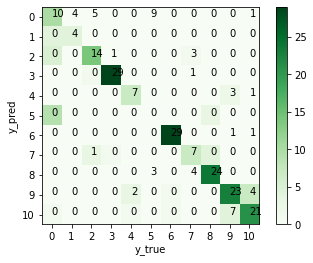

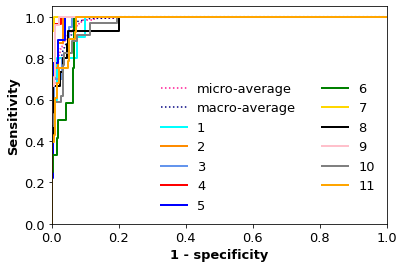

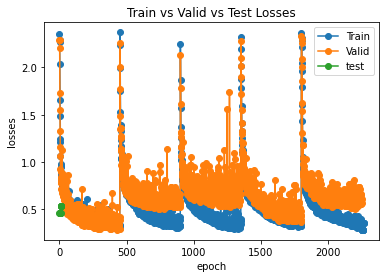

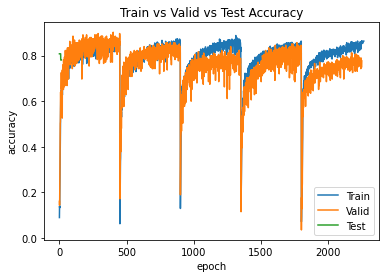

In [15]:
test_metrics(model_final,device,test_loader)

# plot training & testing loss ======================================================
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid','test'])
plt.title('Train vs Valid vs Test Losses')
plt.show()

# plot training & testing accuracy ======================================================
plt.plot(train_acc)
plt.plot(eval_acc)
plt.plot(test_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid','Test'])
plt.title('Train vs Valid vs Test Accuracy')
plt.savefig("Accuracy_All-class.png")
plt.show()

In [79]:
# UMAP visualization
second_layer_output = visualization(model_final,device,all_loader)

mapper = umap.UMAP().fit(second_layer_output.squeeze().cpu())
#mapper = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean').fit(all_data.data.squeeze())
umap.plot.points(mapper,labels=all_data.label.squeeze())
plt.savefig("UMAP_All-class.png")

KeyError: 'fft'

In [ ]:
print(max(train_acc))
print(max(eval_acc))
print(max(test_acc))

In [ ]:
# tensorboard --logdir="D:\Xin Zhang\Sensor\conbination\combination_log"